## Validating step2 script
* 09/27: created 

In [1]:
!python --version

Python 2.7.13 :: Continuum Analytics, Inc.


In [2]:
import os

os.environ['CONDA_DEFAULT_ENV']

'K2phot'

In [3]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline
import os 

## raw

In [10]:
inputpath = '/home/jp/github/transit/cranky/output/24866269/detrended_lc_24866269.txt'
outputfolder = 'output/'
starname='24866269'

lc = np.loadtxt(inputpath,comments='#',delimiter=' ', dtype=float)
t,f=lc[:,0],lc[:,1]

best period is 
1.75571044823


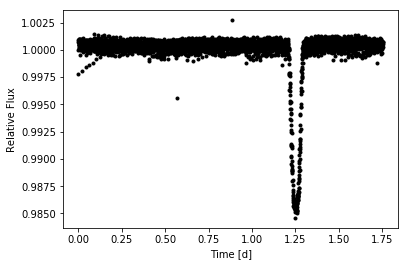

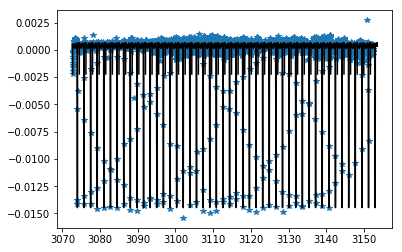

In [11]:
from k2crank.periodfinder import get_period
from k2crank.findplanet import find_period

use_BLS=True

if use_BLS:
    folded,t_folded,period,freqlist,powers = get_period(t,f,[],
                                            get_mandelagolmodel=False,
                                            outputpath=outputfolder,
                                            starname=starname)
else: #Lomb-Scargle periodogram
    period,powers=find_period(t,f,outputfolder=outputfolder,starname=starname)

In [12]:
def estimate_k(t,f,p,showfig=False):
    '''
    k=Rp/Rs estimate transit depth assumed to be within 0.01 percentile
    '''
    baseline,minimum=np.percentile(f[np.array(t%p).argsort()], [50,1])
    if showfig:
        pl.hist(f[np.array(t%p).argsort()]);
    #print(baseline,minimum)
    return np.sqrt(baseline-minimum)

k=estimate_k(t,f,period)

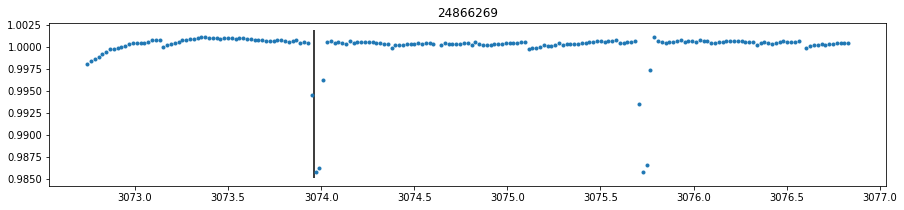

In [13]:
def estimate_t0(t,f,tlower=None,tupper=None, showfig=False,outputfolder='',starname=''):
    '''
    very basic search for t0 given interval tlower and tupper
    '''
    if tlower is None and tupper is None:
        tlower, tupper=t[0],t[200]
    idx = (t > tlower) & (t < tupper)
    tsub, fsub = t[idx], f[idx]
    idx = fsub < np.median(fsub) - 0.5 * np.nanstd(fsub)
    t0 = np.median(tsub[idx])
    if showfig:
        fig, ax = pl.subplots(1,1,figsize=(15,3))
        ax.plot(tsub, fsub, '.')
        ax.set_title(starname)
        ax.vlines(t0, *ax.get_ylim())
    return t0

t0 = estimate_t0(t,f,tlower=t[0],tupper=t[200],showfig=True,outputfolder=outputfolder,starname=starname)

In [14]:
def get_tns(t, p, t0):
    '''
    determine transit conjuctions
    '''

    idx = t != 0
    t = t[idx]

    while t0-p > t.min():
        t0 -= p
    if t0 < t.min():
        t0 += p

    tns = [t0+p*i for i in range(int((t.max()-t0)/p+1))]

    while tns[-1] > t.max():
        tns.pop()

    while tns[0] < t.min():
        tns = tns[1:]

    return tns

tns=get_tns(t, period, t0)

In [15]:
def estimate_t14(value=0.01):
    if value:
        return value
    
def t14_circ(p, a, k, b):
    """
    Winn 2014 ("Transits and Occultations"), eq. 14
    """
    i = inclination(a, b)
    alpha = np.sqrt( (1 + k)**2 - b**2 )
    return (p / np.pi) * np.arcsin( alpha / np.sin(i) / a )

def scaled_a(p, t14, k, i=np.pi/2, b=0):
    numer = np.sqrt( (k + 1)**2 - b**2 )
    denom = np.sin(i) * np.sin(t14 * np.pi / p)
    return float(numer / denom)

def inclination(a, b, e=None, w=None):
    """
    Winn 2014 ("Transits and Occultations"), eq. 7
    """
    # if e is None and w is None:
    #     return np.arccos(b / a)
    # elif e is not None and w is not None:
    #     return np.arccos(b / a * (1 + e * np.sin(w)) / (1 - e**2))
    # else:
    #     return np.nan
    return np.arccos(b / a)

def q_to_u(q1, q2):
    u1 = 2 * np.sqrt(q1) * q2
    u2 = np.sqrt(q1) * (1 - 2*q2)
    return u1, u2

def u_to_q(u1, u2):
    q1 = (u1 + u2)**2
    q2 = u1 / (2 * (u1 + u2))
    return q1, q2


def tshape_approx(a, k, b):
    """
    Seager & Mallen-Ornelas 2003, eq. 15
    """
    i = inclination(a, b)
    alpha = (1 - k)**2 - b**2
    beta = (1 + k)**2 - b**2
    return np.sqrt( alpha / beta )


def max_k(tshape):
    """
    Seager & Mallen-Ornelas 2003, eq. 21
    """
    return (1 - tshape) / (1 + tshape)

In [16]:
p = period
k = estimate_k(t,f,p)
b = 0.1
#estimate initial for t14
t14 = estimate_t14()
a_au = scaled_a(p, t14, k, b=b)
t14 = t14_circ(p, a_au, k, b=b)

#i = inclination(a_au, b=b) #np.pi/2.

#u1, u2 = 0.2, 0.2
#q1, q2=u_to_q(u1, u2)
q1,q2 = 0.2,0.2

sig = f.std()

tshape=tshape_approx(a_au, k, b)
tshape_lim=max_k(tshape)

initial = k,t0,p,a_au,b,q1,q2,sig
args = (t, f)

In [17]:
def model_q(theta, t):
    MA = MandelAgol()
    k,tc,p,a,b,q1,q2,_ = theta
    i     = inclination(a, b)
    u1,u2 = q_to_u(q1, q2)
    model = MA.evaluate(t, k, (u1,u2), tc, p, a, i)

    return model


def lnlike(theta, t, f):
    k,t0,p,a,b,q1,q2,sig = theta
    m = model_q(theta, t)
    resid = f - m
    inv_sigma2 = 1.0/(sig**2)

    return -0.5*(np.sum((resid)**2*inv_sigma2 - np.log(inv_sigma2)))

from scipy import stats

def lnprob(theta, t, f):
    k,t0,p,a,b,q1,q2,sig = theta
    #logprior
    if q1 < 0 or q1 > 1 or q2 < 0 or q2 > 1 or b < 0 or b > 1 or k < 0 or k > 1:
        return -np.inf

    u1, u2 = q_to_u(q1, q2)

    lp = 0
#     if up is not None:
#         lp += np.log(stats.norm.pdf(u1, loc=up[0], scale=up[1]))
#         lp += np.log(stats.norm.pdf(u2, loc=up[2], scale=up[3]))

    #loglike
    ll = lnlike(theta, t, f)

    if np.isnan(ll).any():
        return -np.inf
    return lp + ll

In [18]:
from pytransit import MandelAgol
import scipy.optimize as op



def fit_folded_lc(initial, args, method='powell',verbose=True):
    '''
    `Powell` method minimises the function by a bi-directional search along each search vector, in turn
    '''
    nlp = lambda *args: -lnprob(*args)

    opt = op.minimize(nlp, initial, args=args, method=method)
    labels='k,t0,p,a,i,q1,q2,sig'.split(',')

    if verbose:
        print('converged: {}'.format(opt.success))
        for i,j in zip(labels,opt.x):
            print('{0}: {1}'.format(i,j))
    return opt

opt=fit_folded_lc(initial, args)

/home/jp/miniconda2/envs/K2phot/lib/python2.7/site-packages/scipy/optimize/optimize.py:1850: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


converged: True
k: 0.099211421117
t0: 3073.97829331
p: 1.75555187719
a: 7.26474554458
i: 0.396053017348
q1: 0.772178775602
q2: 0.999547981496
sig: -0.000567453263603


In [19]:
def fold(t, f, p, t0, width=0.4, clip=False, bl=False, t14=0.1):
    '''
    fold lc; very sensitive to p & t0
    '''
    tns = get_tns(t, p, t0)
    tf, ff = np.empty(0), np.empty(0)
    for i,tn in enumerate(tns):
        idx = (t > tn - width/2.) & (t < tn + width/2.)
        ti = t[idx]-tn
        fi = f[idx]
        fi /= np.nanmedian(fi)
        if bl:
            idx = (ti < -t14/2.) | (ti > t14/2.)
            assert np.isfinite(ti[idx]).all() & np.isfinite(fi[idx]).all()
            assert idx.sum() > 0
            try:
                res = sm.RLM(fi[idx], sm.add_constant(ti[idx])).fit()
                if np.abs(res.params[1]) > 1e-2:
                    print('bad data probably causing poor fit')
                    print('transit {} baseline params: {}'.format(i, res.params))
                    continue
                model = res.params[0] + res.params[1] * ti
                fi = fi - model + 1
            except:
                print("error computing baseline for transit {}".format(i))
                print("num. points: {}".format(idx.sum()))
                print(ti)
        tf = np.append(tf, ti)
        ff = np.append(ff, fi / np.nanmedian(fi))
    idx = np.argsort(tf)
    tf = tf[idx]
    ff = ff[idx]
    if clip:
        fc = sigma_clip(ff, sigma_lower=10, sigma_upper=2)
        tf, ff = tf[~fc.mask], ff[~fc.mask]
    return tf, ff

def plot_fit(theta,t,f,show_model=True,outputfolder='',starname=''):
    t0, p = theta[1], theta[2]

    tf, ff = fold(t, f, p, t0)
    #ff /= np.median(ff)

    fig, ax = pl.subplots(1,1,figsize=(15,5))
    ax.plot(tf, ff, '.', label='data')
    ax.set_xlabel('Phase')
    ax.set_ylabel('Normalized Flux')
    fmod=model_q(theta, t)
    ttmod,ffmod=fold(t,fmod,p,t0)
    ax.plot(ttmod,ffmod,'r.-',label='model')
    ax.set_title('Phase-folded with model fit (MLE): {}'.format(starname))
    ax.legend()
    #pl.savefig(join(outputfolder, 'folded_model_optimized_fit' + str(starname) + '.png'))

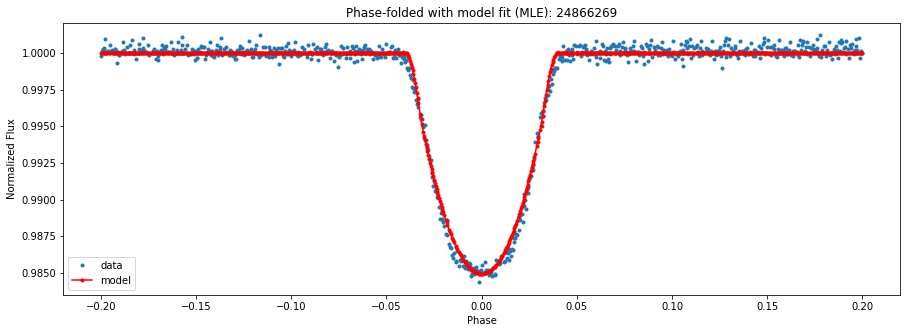

In [20]:
plot_fit(opt.x,t,f,outputfolder=outputfolder,starname=starname)

In [21]:
tshape=tshape_approx(a_au, k, b)
tshape

0.78431925289841675

In [22]:
tshape_lim=max_k(tshape)
tshape_lim

0.12087564865493394

In [23]:
snr = np.max(powers)/np.median(powers)
snr

19.595399090940425

In [24]:
np.rad2deg(inclination(a_au, b))

89.908070736401925

## Summary plot